# **ptj2 - CLIP 모델의 다양한 활용**
    
    과제 목표
        1. CLIP 모델 Architecture의 정성적 이해
        2. 학습된 CLIP 멀티모달 모델을 활용한 Image Classification
        3. 학습된 CLIP 멀티모달 모델을 활용한 Image-Text Matching Task
        4. 학습된 CLIP 멀티모달 모델을 응용한 Text2Image 모델 학습 및 활용
        
    CLIP [1] 이란?
    : OpenAI에서 만든 멀티모달 모델을 지칭하는 단어로, "Contrastive Language-Image Pre-Training"의 약자이기도 합니다.
      직역해보자면 "언어와 이미지 데이터를 Constrastive Learning으로 사전 학습 시키기" 라고 할 수 있는데,
      이름에서 알수있듯 "이미지"와 "텍스트" 두 가지 다른 타입의 데이터로 학습을 하기 때문에 멀티모달: 모델로 분류됩니다.

      CLIP을 활용하면 이미지와 텍스트로부터 유용한 공통 특징 (feature) 공간의 feature를 추출할 수 있고 이를 활용하여 다양한 task를 수행할 수 있습니다.
      [1] Radford et al., Learning Transferable Visual Models From Natural Language Supervision, International Conference on Machine Learning (ICML), 2021.

## **CLIP의 전체적 학습 과정**
<br>

![image](https://drive.google.com/uc?id=13nymBlxVY2hoUw8t1_cfp3p7dv5baFme)

    논문 Figure.1) CLIP 모델의 학습 과정 도식도
　  **Fig.1 - (1)** <br>
　　　CLIP에서 수행한 Constrastive Learning을 보여줍니다. <br>
　　　Image Encoder에서 나온 feature vector들이 I<sub>1</sub>, I<sub>2</sub>, I<sub>3</sub>, ... <br>
　　　Text Encoder에서 나온 feature vector들은 T<sub>1</sub>, T<sub>2</sub>, T<sub>3</sub>, ... <br>
　　　이며, 각각의 벡터들의 내적 값을 구한 것을 행렬로 표현하고 있습니다.  <br> 　　　대각성분은(하늘색) 이미지와 텍스트의 의미가 맞는 sample(Positive sample)을 의미하며 <br>
　　　그 외의 성분은 모두 다른 의미를 가지고 Negative sample이라고 합니다.

　　**Fig.1 - (2)** <br>
　　　Text Encoder에 각 label text dataset을 넣어서 각각의 feature vector를 뽑아냅니다. <br>
　　　마치 첫번째 그림의 a cat staring front, a cat running backward 문장들이 바로 ladel text dataset의 예시로 볼 수 있습니다. <br>

　　**Fig.1 - (3)** <br>
　　　Image Encoder에 원하는 input 이미지를 넣고, Text encoder에서 나온 각각의 feature vector와 비교하여 similarity를 구합니다. <br>
　　　이 중 가장 높은 silmilarity를 보이는 문장이 바로 input 이미지와 가장 유사한 의미의 문장이라고 볼 수 있습니다. <br>
　　　zero-shot prediction 이라고 표현한 이유는, 추가적 학습없이 임의의 image와 text를 비교하는 task이기 때문입니다.

#### Contrastive Learning
    
    위 논문의 Fig.1은 Contrastive Pre-training으로부터 시작합니다. Contrastive Learning이란 무엇일까요?
    단어의 의미에서 유추할 수 있듯 서로 다른 경로에서 온 데이터 Feature를
    서로 대조하여 그 '차이'를 학습하는 것을 Contrastive Learning이라 합니다.
    아래의 그림은 강의에서 다룬 내용인데요, Contrastive learning의 한 학습 예시를 보여줍니다.
     
<br>

![image](https://drive.google.com/uc?id=1arkUckpZxR8oL1aQeQItHxWv1uSm-q9G)

<br>
    
    위의 그림은 Multi-Modal 학습을 위한 Metric Learning의 과정을 보여주고 있습니다.

    Joint Embedding 공간에서 Matching 되는 데이터끼리는 서로 가깝게,
    Non-Matching 되는 데이터끼리는 서로 멀어지게끔 학습을 하게 됩니다.

    예시 그림에는 동일한 토끼 그림 2개와 각각 짝을 이루는 텍스트(어구 혹은 문장)가 주어졌습니다.

    이 때 model은 주어진 각 그림과 텍스트로부터 나온 feature vector를 비교하여
    서로 동일한 의미를 지니는 벡터끼리는 Joint Embedding 공간에서 거리를 더욱 가깝게,
    서로 다른 의미를 가지면 거리를 더욱 멀어지게 학습하게 됩니다.
    
    따라서 Contrastive Learning에서는 '다르다' 혹은 '유사하다' 라는 기준을 어떻게 잡을지(=labeling 이슈),
    비교를 위한 metric은 무엇으로 정의할지(예를 들어 Euclidean distance, Cosine similarity 등등) 등이 중요 사안입니다.
    

### CLIP의 git repo를 clone하고 필요한 pakage들을 설치

In [ ]:
!git clone https://github.com/openai/CLIP.git

In [ ]:
pip install git+https://github.com/openai/CLIP.git

In [ ]:
pip install ftfy regex tqdm

In [1]:
import os
import PIL
import clip
import torch
import random
import imageio
import requests
import numpy as np
from io import BytesIO
from tqdm import tqdm
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms.functional as TF
from torch.nn import CosineSimilarity as CosSim

## **1. 모델 불러오기 및 간단한 테스트**
    CLIP 모델을 활용하여 다양한 image와 text로 부터 성능을 테스트해보고, feature vector를 추출해보겠습니다. 코드는 CLIP 공식 github을 참고하였습니다.
    

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# GPU 메모리 약 1.5 GB 필요 --> 만일 부족하다면 clip.available_models() 명령어를 통해 가지고 오는 모델을 바꿀 수 있습니다
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 30.5MiB/s]


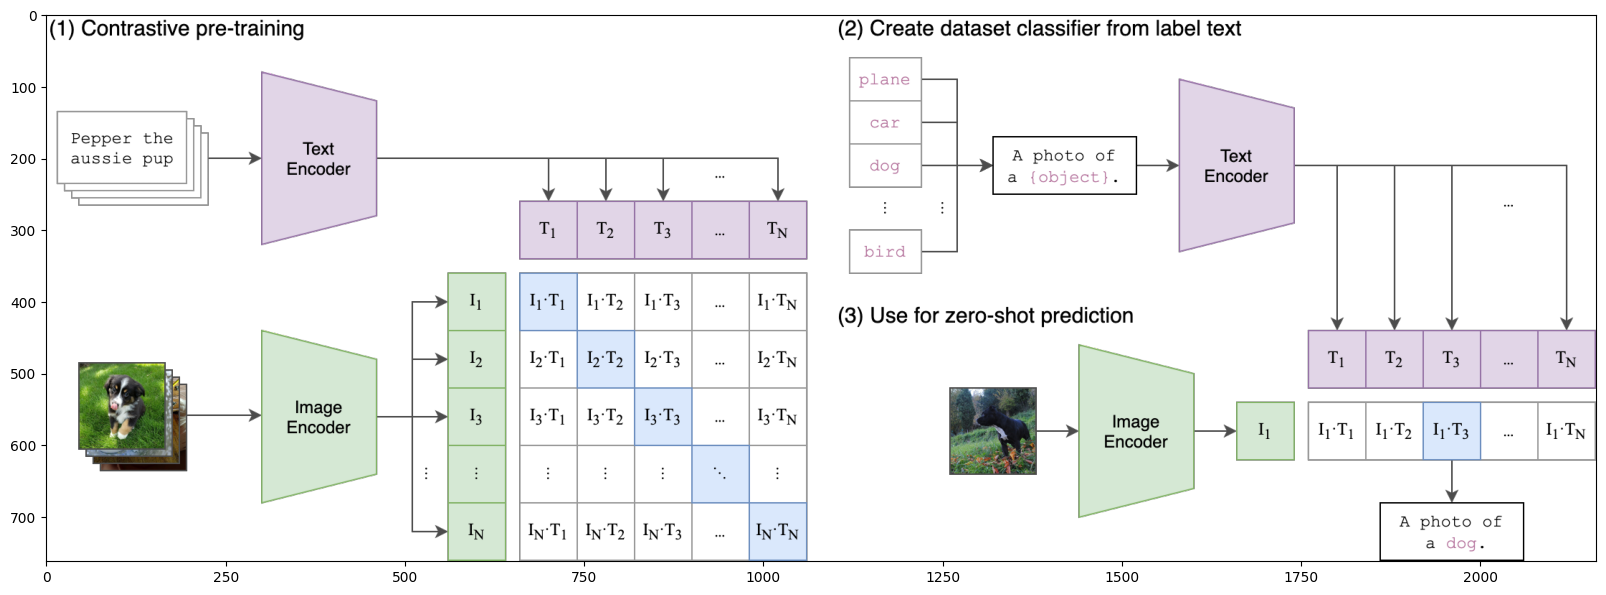

In [ ]:
# Test 이미지를 불러오기
image_path = "./CLIP/CLIP.png"
plt.figure(figsize=(20, 20))
plt.imshow(Image.open(image_path))
plt.show()

#### CLIP 논문의 Figure.1 일부분이 Crop된 이미지가 출력된 것을 보실 수 있습니다.
#### 이제 이 그림을 가지고 Text 매칭을 시켜보겠습니다.



In [ ]:
# image encoder에 넣을 수 있도록 전처리를 합니다.
# preprocess 함수는 (224, 224)로 Resize를 해주고 Normalization을 해줍니다.
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

##### 어떤 단어가 위 Figure1을 표현할 수 있을까요? 우선 a diagram, a dog, a cat 이라는 단어들로 테스트를 해보겠습니다.

In [ ]:
# Test 하고자 하는 임의의 문장 or 어구
text_dataset = ["a diagram", "a dog", "a cat"]

# CLIP 모델 안에는 tokenizer가 내장되어있습니다. 각 단어를 숫자로 변환해줍니다.
text = clip.tokenize(text_dataset).to(device)

#### 각 image와 text의 유사도 구해보기

In [ ]:
with torch.no_grad():

    # 모델에 image와 text 둘 다 input으로 넣고, 각 text와 image와의 유사도를 구합니다. 값이 클수록 유사합니다.
    logits_per_image, _ = model(image, text)

    # 확률값으로 표현하기 위해 softmax를 값을 구합니다.
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

print("- Text와 image의 유사도 값 -")
for idx in range(len(text_dataset)):
    print("  "+text_dataset[idx] + ":", logits_per_image.cpu().numpy().flatten()[idx])

print("\n- 각 Text가 image와 일치할 확률 -")
for idx in range(len(text_dataset)):
    print("  "+text_dataset[idx] + ":", round(probs[idx]*100, 3) , "%")

- Text와 image의 유사도 값 -
  a diagram: 25.55
  a dog: 20.1
  a cat: 19.73

- 각 Text가 image와 일치할 확률 -
  a diagram: 99.268 %
  a dog: 0.425 %
  a cat: 0.297 %


    　input 이미지는 dog나 cat보다 diagram과 의미상 더 유사하다고 볼 수 있는데요, 확률값도 이를 잘 반영하고 있습니다.
    　이처럼 CLIP을 활용하면 text와 image 간의 유사한 정도를 쉽게 구할 수 있습니다.  
    　이제부터는 다양한 이미지와 텍스트에 대해서 CLIP을 활용하여 유사도를 구해보겠습니다.

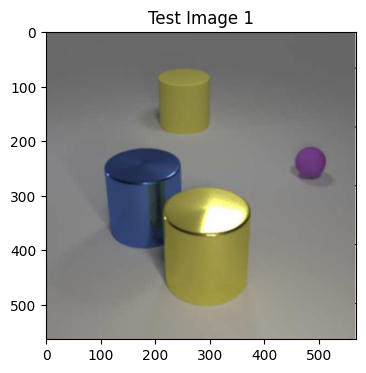

- Text와 image의 유사도 값 -
  a photo of 1 objects: 25.33
  a photo of 3 objects: 27.02
  a photo of 4 objects: 27.36
  a photo of 5 objects: 27.05
  a photo of 10 objects: 25.8

- 각 Text가 image와 일치할 확률 -
  a photo of 1 objects: 4.715 %
  a photo of 3 objects: 25.488 %
  a photo of 4 objects: 35.962 % (실제 정답)
  a photo of 5 objects: 26.294 %
  a photo of 10 objects: 7.538 %


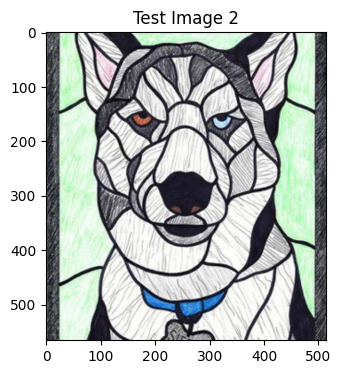

- Text와 image의 유사도 값 -
  a photo of a german shepherd dog: 24.5
  a photo of a collie: 23.83
  a photo of a border collie: 22.6
  a photo of a siberian husky: 25.84
  a photo of a rottweiler: 21.3

- 각 Text가 image와 일치할 확률 -
  a photo of a german shepherd dog: 18.066 %
  a photo of a collie: 9.229 %
  a photo of a border collie: 2.686 %
  a photo of a siberian husky: 69.287 % (실제 정답)
  a photo of a rottweiler: 0.734 %


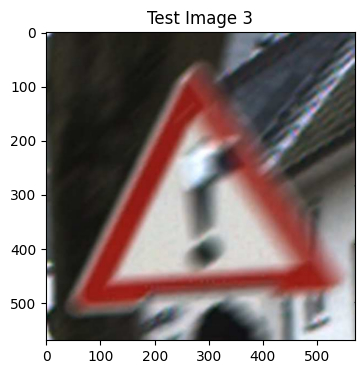

- Text와 image의 유사도 값 -
  a zoomed in photo of a "red and white triangle with exclamation mark warning" traffic sign: 36.25
  a zoomed in photo of a "red and white triangle with black right curve approaching warning" traffic sign: 35.88
  a zoomed in photo of a "red and white triangle car skidding / slipping warning" traffic sign: 36.16
  a zoomed in photo of a "red and white triangle rough / bumpy road warning" traffic sign: 36.1
  a zoomed in photo of a "red and white triangle with black left curve approaching warning" traffic sign: 36.28

- 각 Text가 image와 일치할 확률 -
  a zoomed in photo of a "red and white triangle with exclamation mark warning" traffic sign: 22.302 % (실제 정답)
  a zoomed in photo of a "red and white triangle with black right curve approaching warning" traffic sign: 15.32 %
  a zoomed in photo of a "red and white triangle car skidding / slipping warning" traffic sign: 20.3 %
  a zoomed in photo of a "red and white triangle rough / bumpy road warning" traffic sign: 19.067 

In [ ]:
image_urls = ['https://url.kr/qcutfr',
              'https://url.kr/m745rv',
              'https://url.kr/i3u6yd'] # 테스트 이미지 링크
texts = [["a photo of 1 objects", "a photo of 3 objects", "a photo of 4 objects", "a photo of 5 objects", "a photo of 10 objects"],
         ["a photo of a german shepherd dog", "a photo of a collie", "a photo of a border collie", "a photo of a siberian husky", "a photo of a rottweiler"],
         ["a zoomed in photo of a \"red and white triangle with exclamation mark warning\" traffic sign",
          "a zoomed in photo of a \"red and white triangle with black right curve approaching warning\" traffic sign",
          "a zoomed in photo of a \"red and white triangle car skidding / slipping warning\" traffic sign",
          "a zoomed in photo of a \"red and white triangle rough / bumpy road warning\" traffic sign",
          "a zoomed in photo of a \"red and white triangle with black left curve approaching warning\" traffic sign"]] # 테스트 텍스트 데이터
labels = [2, 3, 0]

# 한번의 for loop에서 하나의 이미지, 텍스트 데이터에 대해서 유사도 및 확률값을 구합니다.
for idx, path in enumerate(image_urls):
    img = Image.open(BytesIO(requests.get(path).content))

    plt.figure(figsize=(4,4))
    plt.title(f"Test Image {idx+1}")
    plt.imshow(img)
    plt.show()

    # 이미지와 텍스트를 벡터로 만들고 유사도와 확률값을 구합니다.
    image = preprocess(img).unsqueeze(0).to(device)
    text_dataset = texts[idx]
    text = clip.tokenize(text_dataset).to(device)
    with torch.no_grad():
        logits_per_image, _ = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

    print("- Text와 image의 유사도 값 -")
    for i in range(len(text_dataset)):
        print("  "+text_dataset[i] + ":", logits_per_image.cpu().numpy().flatten()[i])

    print("\n- 각 Text가 image와 일치할 확률 -")
    for i in range(len(text_dataset)):
        if i == labels[idx]:
            print("  "+text_dataset[i] + ":", round(probs[i]*100, 3) , "% (실제 정답)")
        else:
            print("  "+text_dataset[i] + ":", round(probs[i]*100, 3) , "%")

    위 결과를 보면 사전 학습 전혀없이 "물체가 몇 개가 있는지", "이 그림이 시베리안 허스키인지"
    혹은 "표지판의 의미가 무엇인지" 등을 정답을 가장 높은 확률값으로 추정하는 것을 확인할 수 있습니다.

#### image encoder와 text encoder를 활용하여 각 image와 text에 대응하는 feature 벡터 만들기

    앞선 과정은, model에 image와 text를 한번에 input으로 넣고 곧바로 유사도를 얻었습니다.
    그렇지만 때때로 input 데이터의 feature를 추출해야할 때도 있습니다.
    
    이제부터는 feature vector를 각 input에 대해 얻고 그로부터 유사도를 구해보겠습니다.

In [ ]:
# 앞서 활용한 Test 이미지와 텍스트를 그대로 활용하겠습니다.
image_path = "./CLIP/CLIP.png"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
text_dataset = ["a diagram", "a dog", "a cat"]
text = clip.tokenize(text_dataset).to(device)

# model의 image encoder와 text encoder에 각각의 데이터를 넣어줍니다.
with torch.no_grad():
    image_features = model.encode_image(image) # 이미지 feature 추출
    text_features = model.encode_text(text)    # 텍스트 feature 추출
print(image_features.shape, text_features.shape)

torch.Size([1, 512]) torch.Size([3, 512])


##### 각 이미지와 text 데이터가 512차원의 feature 벡터로 변환되었음을 확인할 수 있습니다.
##### 이제 feature 벡터에서 유사도를 구하고, 앞서 구했었던 유사도와 정말로 동일한 값을 주는지 확인해보겠습니다.

In [ ]:
# feature vector로부터 유사도 계산을 위해 Cosine Similarity 함수를 활용하겠습니다.
cos_sim = CosSim(dim=1)
logits = cos_sim(image_features, text_features)*100 # similarity의 최대값을 100점처럼 표현하기 위해 편의상 CLIP에서는 100을 곱합니다.
probs = logits.softmax(dim=-1).cpu().numpy().flatten()

In [ ]:
print("- Text와 image의 유사도 값 -")
for idx in range(len(text_dataset)):
    print("  "+text_dataset[idx] + ":", logits.cpu().numpy().flatten()[idx])

print("\n- 각 Text가 image와 일치할 확률 -")
for idx in range(len(text_dataset)):
    print("  "+text_dataset[idx] + ":", round(probs[idx]*100, 3) , "%")

- Text와 image의 유사도 값 -
  a diagram: 25.53
  a dog: 20.08
  a cat: 19.73

- 각 Text가 image와 일치할 확률 -
  a diagram: 99.268 %
  a dog: 0.425 %
  a cat: 0.302 %


##### 앞서 model에 이미지와 텍스트를 한번에 넣어 구한 값(아래)과 비교하여 어떤가요?
    - Text와 image의 유사도 값 -
      a diagram: 25.55
      a dog: 20.08
      a cat: 19.75

    - 각 Text가 image와 일치할 확률 -
      a diagram: 99.268 %
      a dog: 0.418 %
      a cat: 0.302 %
거의 동일한 값임을 확인할 수 있습니다.


#### **Req. 1-1** ####
아래 주석 지시를 따라 이제 자신만의 이미지와 텍스트 데이터로 Feature를 추출하고, 유사도를 구하여 확률값을 출력해보겠습니다. <br>
어렵다고 생각되는 부분은 앞의 코드를 참고해보세요.

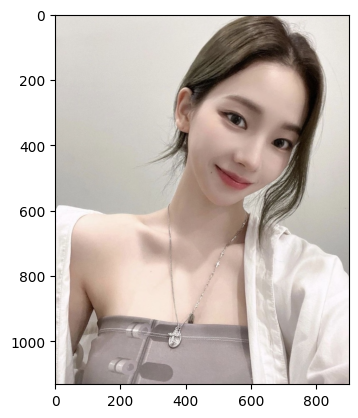

torch.Size([1, 512]) torch.Size([5, 512])


In [ ]:
# 테스트 해보고 싶은 이미지의 인터넷 링크 주소를 입력하세요.
#image_url = "      "
#img = Image.open(BytesIO(requests.get(image_url).content))
image_path = "/content/karina.jpeg"
img = Image.open(image_path)
plt.imshow(img)
plt.show()
image = preprocess(img).unsqueeze(0).to(device)

# 테스트 해보고 싶은 어구 또는 문장을 입력하세요.
# NOTE: CLIP 모델 encoder는 입력받는 문장의 단어 개수가 77개가 넘어서는 안됩니다.
text_dataset = ["a girl with short black hair", "a girl with pink lips", "a girl wearing off shoulder", "a girl wearing a gold necklace", "a girl wearing a white shirt"]

# CLIP에서 제공하는 토크나이저를 사용(위 코드 참조)합니다.
text = clip.tokenize(text_dataset).to(device)

# model의 image encoder와 text encoder에 각각의 데이터를 넣어줍니다.
with torch.no_grad():
    image_features = model.encode_image(image)      # 이미지 feature 추출
    text_features = model.encode_text(text)      # 텍스트 feature 추출

print(image_features.shape, text_features.shape)

In [ ]:
# Cosine Similarity 함수를 활용하여 Similarity를 구합니다.
logits = cos_sim(image_features, text_features) * 100     # similarity의 최대값을 100점처럼 표현하기 위해 편의상 CLIP에서는 100을 곱합니다. (위 코드 참조)
probs =  logits.softmax(dim = -1).cpu().numpy().flatten()

print("- Text와 image의 유사도 값 -")
for idx in range(len(text_dataset)):
    print("  "+text_dataset[idx] + ":", logits.cpu().numpy().flatten()[idx])

print("\n- 각 Text가 image와 일치할 확률 -")
for idx in range(len(text_dataset)):
    print("  "+text_dataset[idx] + ":", round(probs[idx]*100, 3) , "%")

- Text와 image의 유사도 값 -
  a girl with short black hair: 24.94
  a girl with pink lips: 25.17
  a girl wearing off shoulder: 28.73
  a girl wearing a gold necklace: 27.31
  a girl wearing a white shirt: 27.86

- 각 Text가 image와 일치할 확률 -
  a girl with short black hair: 1.313 %
  a girl with pink lips: 1.66 %
  a girl wearing off shoulder: 58.496 %
  a girl wearing a gold necklace: 14.124 %
  a girl wearing a white shirt: 24.39 %


#### **Req. 1-2** ####
자신이 생각한 정답과 이미지가 잘 일치하나요? 위 코드를 변형해가며 다양한 이미지로 테스트를 해보면서 모델 성능을 확인해보세요.

## **2. Zero-shot Image Classification**    

##### CIFAR-100 Dataset을 Zero-shot으로 Image Classification을 해보겠습니다.

#### **Req. 1-3** ####
아래 주석의 지시를 따라 구현해주세요

Files already downloaded and verified


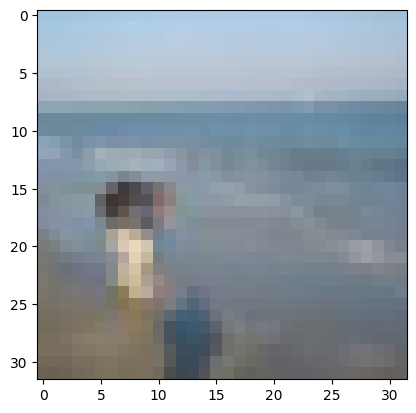


Top predictions:

           plain: 8.70%
            girl: 10.16%
             sea: 36.60%


In [ ]:
# CIFAR100 dataset을 다운로드 받습니다.
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# CIFAR 100 모든 classes의 어구를 만들고 토큰화합니다.
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# 임의의 input 이미지를 선정.
image_index = 4000       #  image_index 값은 0~9999 까지 입력이 가능합니다. 자유롭게 선택해보세요.
image, _ = cifar100[image_index]
plt.imshow(image)
plt.show()

# 이미지 전처리 및 feature 추출
image_inputs = preprocess(image).unsqueeze(0).to(device)       # CLIP 모델의 전처리 모듈 사용 (위 코드 참조)

with torch.no_grad():
    image_features = model.encode_image(image_inputs)          # 이미지 feature 추출
    text_features = model.encode_text(text_inputs)           # 텍스트 feature 추출

# Cosine Silmilarity 계산
similarity = cos_sim(image_features, text_features)*100       # similarity의 최대값을 100점처럼 표현하기 위해 편의상 CLIP에서는 100을 곱합니다. (위 코드 참조)


K = 3
probs = similarity.softmax(dim = -1).cpu().numpy().flatten()

indices = probs.argsort()[-K:]

values = probs[indices]        # softmax 함수로 가장 높은 K개의 확률값 구하기

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100*value.item():.2f}%")

#### **Req. 1-4** ####
위의 image_index=3000 변수 값을 바꿔가며 CLIP 모델이 어떤 이미지를 잘 분류하고 어떤 이미지에는 취약한지 확인해보세요. 그리고 그 이유는 무엇일지 고민해보세요.

In [ ]:
## 서술형 답변 TODO ##
# 잘 분류하는것 같은데???
# 취약한 이미지가 있다면... 사전학습 과정에서 그러한 이미지를 학습하지 못했기 때문
#
#
#
#
#

#### **Req. 1-5** ####
CLIP 모델을 활용한 간단한 스무고개 게임을 만들어 보세요.
    
예를 들어 자동차 사진이 하나 주어진다면,
처음에는 노이즈가 많이 들어간 자동차 사진으로 사람이 추측해봅니다. 추측한 단어를 입력한 후 확률값을 확인하여
만일 정답(자동차)의 label이 50%를 넘지 못한다면 이번엔 노이즈가 적게 들어간 사진을 제시합니다.
다시 추측하여 단어를 입력 후 확률값을 확인해봅니다.
    
이런식으로 사람이 맞출 때까지 사진을 더 선명하게 바꿔가며 스무고개 게임을 만들어,
주변 친구나 가족에게 혹은 스스로 테스트 해봅니다.  

위에서 사용한 코드와 모듈을 적극 활용해주세요.

In [ ]:
pip install opencv-python

In [ ]:
from torchvision.transforms import v2

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #AddGaussianNoise(mean = 0.9, std = 0.9)
])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

사진은 무엇일까요?



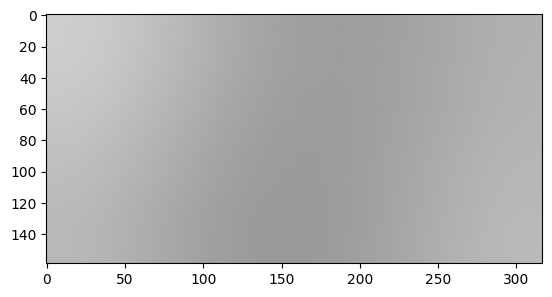

1번째 시도: 자동차
정답이 아닙니다.
조금 더 선명하게 보여드릴게요.


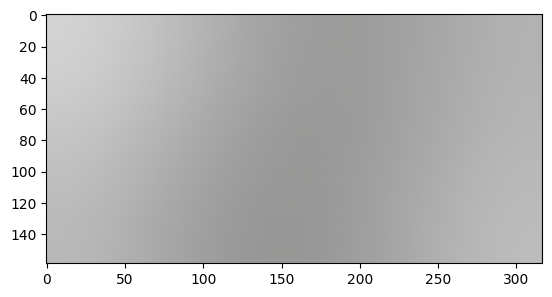

2번째 시도: 자동차
정답이 아닙니다.
조금 더 선명하게 보여드릴게요.


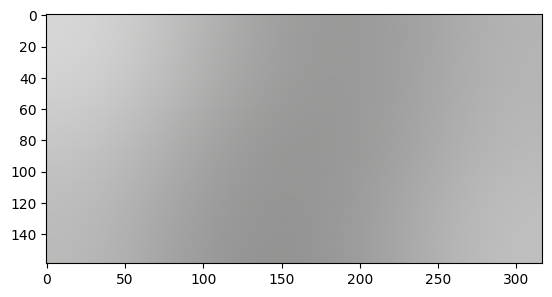

3번째 시도: 자동차
정답이 아닙니다.
조금 더 선명하게 보여드릴게요.


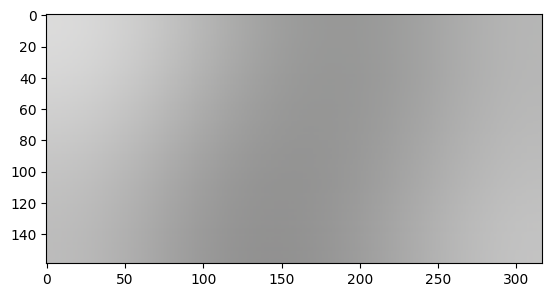

4번째 시도: 차
정답입니다!


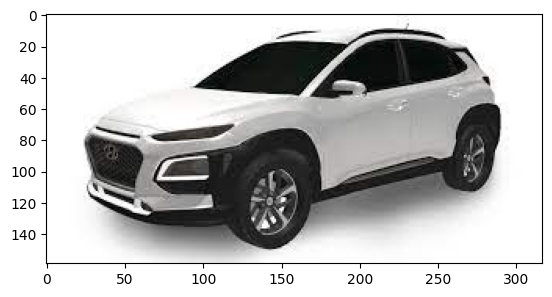



자동차


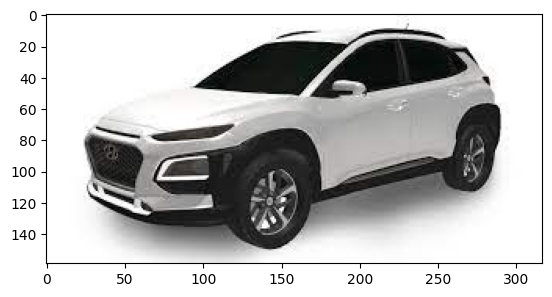

In [ ]:
## CLIP 스무고개

### TODO ###

import random
import cv2
import time

def OpenCV2PIL(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(color_coverted)
    return pil_image

cos_sim = CosSim(dim=1)

def clip_check(model,preprocess,image,text,answer):

    image_inputs = preprocess(OpenCV2PIL(image)).unsqueeze(0).to(device)
    text_inputs = clip.tokenize([text,answer]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_inputs)
        text_features = model.encode_text(text_inputs)

    similarity = cos_sim(image_features, text_features)*100

    probs = similarity.softmax(dim = -1).cpu().numpy().flatten()

    return probs

def clip_game(image_list,model, preprocess):

    image_path = random.choice(image_list)

    if image_path == '/content/car.jpg':

        answer = '자동차'

    elif image_path == '/content/animal1.jpg':

        answer = '사슴'

    elif image_path == '/content/animal2.jpg':

        answer = '호랑이'

    elif image_path == '/content/animal3.jpg':

        answer = '사자'

    else:

        answer = '곰'

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    sigma = 80

    print('사진은 무엇일까요?')
    print()

    t = 1

    correct = False

    while 1:

        blur_image = cv2.GaussianBlur(image, (0,0), sigma)

        plt.imshow(blur_image)
        plt.show()
        time.sleep(2)

        text = input(f'{t}번째 시도: ')

        p = clip_check(model, preprocess, blur_image, text, answer)

        if p[0] > 0.50:

            print('정답입니다!')

            correct = True
            plt.imshow(image)
            plt.show()
            break

        else:

            print('정답이 아닙니다.')

            if t <= 19:
                sigma -= 4
                if sigma < 0:
                    sigma = 0
                print('조금 더 선명하게 보여드릴게요.')

        t += 1

        if t >= 21:

            break

    print()
    if correct == False:
        print('20번 동안 정답을 못맞췄으니 정답을 공개합니다.')
    print()
    print(answer)

    plt.imshow(image)
    plt.show()

image_list = ['/content/car.jpg','/content/animal1.jpg','/content/animal2.jpg','/content/animal3.jpg','/content/animal4.jpg']

clip_game(image_list, model, preprocess)

## **3. Applications with using CLIP: Text2image**    

    CLIP은 활용범위가 넓어 현재까지 다양한 응용 연구들이 나왔습니다.
    
    아래 소개하는 모델은 Text를 입력하면 그에 맞는 Image를 생성하는 CLIP의 Feature를 이용한 Text2Image 모델입니다.
    직접 원하는 Text를 입력하여 어떤 이미지가 생성되는지 테스트해보세요.

    NOTE: CLIP으로부터 추출한 Feature를 이용하여 생성 모델을 처음부터 학습하므로 다소 시간이 걸립니다.
    　　　10~15분정도 실행시켜놓고 잠시 쉬는 시간을 가져보는 것도 좋을 것 같습니다 :)

    참고 GitHub 코드 링크: https://github.com/tg-bomze/collection-of-notebooks/blob/master/Text2Image.ipynb

In [2]:
#@title 필요 패키지 및 모델 정의 (왼쪽 화살표를 눌러 실행해주세요)
try:
  !pip3 install googletrans==3.1.0a0
  from googletrans import Translator, constants
  from pprint import pprint
  translator = Translator()
except: pass

from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import glob
from google.colab import output
import torch.nn as nn

!mkdir frames
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from google.colab import files
import warnings
from IPython.display import clear_output

mkdir: cannot create directory ‘frames’: File exists


##### 모델 클래스 정의

In [3]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)

  imageio.imwrite('result.png', img.astype(np.uint8))
  file_path = '/content/CLIP/frames/{}.png'.format(str(len(os.listdir('/content/CLIP/frames'))).zfill(5))
  imageio.imwrite(file_path, img.astype(np.uint8))
  return display.Image('result.png')

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords.cuda())
        return output.view(1, sideX, sideY, 3).permute(0, 3, 1, 2)

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def checkin(loss):
  with torch.no_grad():
    al = nom(model(get_mgrid(sideX)).cpu()).numpy()
  for allls in al:
    displ(allls)
    clear_output()
    pic_num = str(len(os.listdir('/content/CLIP/frames')))
    print(f'Picture number {pic_num}\n')
    if int(pic_num) == 1:
      print("\n첫번째 이미지: 초기 이미지는 매우 Noisy 한 것이 일반적입니다.")
    display.display(display.Image('result.png'))
    print('\n다음 이미지 생성 중.. (시간이 다소 걸립니다)')

def ascend_txt():
  out = model(get_mgrid(sideX))

  cutn = 64
  p_s = []
  for ch in range(cutn):
    size = torch.randint(int(.5*sideX), int(.98*sideX), ())
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(nom(apper))
  into = torch.cat(p_s, 0)

  iii = perceptor.encode_image(into)
  t = perceptor.encode_text(tx.cuda())
  return -100*torch.cosine_similarity(t, iii, dim=-1).mean()


nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

In [4]:
# 원하는 CLIP 모델 로드
perceptor, _ = clip.load('ViT-B/32')

warnings.filterwarnings("ignore")
%matplotlib inline
%cd /content/CLIP/
%mkdir frames

clear_output()
!nvidia-smi -L
print('\nDone!')

GPU 0: Tesla T4 (UUID: GPU-c3555ba6-1e0f-e5a4-1eea-b6d99bb69b25)

Done!


##### 세부 파라미터 설정
    아래의 text 변수에 생성 이미지를 묘사하는 텍스트를 입력


In [8]:
text = 'a white cloud in the blue sky'

# 영어 이외의 text를 입력에 대비
translation = translator.translate(text)
prompt = translation.text
tx = clip.tokenize(prompt)

    비록 CLIP의 feature를 활용하지만 생성 모델은 일반적으로 학습에 다소 시간이 걸립니다.
    이미지 해상도(resolution)과 출력빈도(frame_frequency)를 조절해보세요. 128로 할 경우 어느정도 텍스트와 유사한 이미지를 얻기 위해 약 5~10분 정도 소요됩니다.
    
    [변수명]
    resolution: 이미지 가로 세로 해상도. 128은 크기가 작지만 결과가 빠르게 나옵니다.
    frame_frequency: 중간 결과 출력 빈도 (GradientDecent를 통한 모델 업데이트를 몇 번 한 후 출력할지)
    stop_iter: 중간 결과 총 출력 횟수 (stop_iter 만큼 이미지 생성 후 학습 중단. 일반적으로 20~40 정도에서 어느정도 원하는 이미지가 출력됩니다)


In [9]:
resolution = 128     # 예시: 128, 256, 512
frames_frequency = 10 # 예시: 10, 50, 100
stop_iter = 50       # 예시: 10, 20, 50

sideX, sideY, channels = resolution, resolution, 3

#### **Req. 1-6** ####
위에서 정의한 모델 클래스로 모델 인스턴스를 생성하고 optimizer와 학습 스크립트를 구현하고 학습을 진행합니다. TODO를 채워 넣으면 됩니다.

In [ ]:
from tqdm.auto import tqdm

Picture number 50



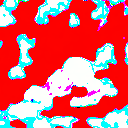


다음 이미지 생성 중.. (시간이 다소 걸립니다)


In [11]:
!rm -rf /content/CLIP/frames/*.*

# 모델 인스턴스 생성
model = Siren(in_features=2, out_features=3, hidden_features=256,
                  hidden_layers=16, outermost_linear=False).cuda()

# optimizer 정의
optimizer = torch.optim.SGD(model.parameters(), lr = 0.000005)### TODO ###
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# 학습 스크립트 구현
# loss 정의, optimizer 초기화, backpropagation, weight update
# loss는 위에서 정의한 ascend_txt 함수를 사용합니다.
for itt in range(stop_iter*frames_frequency):
  ### TODO ###

    loss = ascend_txt()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if itt % 10 == 0:

        checkin(loss)
        #scheduler.step()

#### **비디오 생성**
    지금까지 생성한 이미지들로 비디오를 생성합니다.(이미지 10개=1초)


In [12]:
frames = []
img = os.listdir("/content/CLIP/frames")
img.sort()
for i in img:
  frames.append(imageio.imread("/content/CLIP/frames/"+i))
frames = np.array(frames)
imageio.mimsave('/content/CLIP/video.mp4', frames)
clear_output()

from IPython.display import HTML
import io
import base64
video = io.open('/content/CLIP/video.mp4', 'r+b').read()
encoded = base64.b64encode(video)
play_html = ('<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'.format(encoded.decode('ascii')))
HTML(data=play_html)

#### **이미지 및 영상 다운로드**

In [ ]:
files.download('/content/CLIP/result.png')
files.download('/content/CLIP/video.mp4')

#### **Req. 1-7** ####
다른 텍스트 데이터를 직접 넣어보고, 파라미터를 바꾸어가며 실험 해보세요.